# Cylindrical Nanowire

We study transport properties through a cylindrical nanowire to reproduce orbital Josephson interference. An axial magnetic field is applied along the length of the nanowire. As a result, a vector potential $\vec{A} = A \hat{\phi}$ is present.

The Hamiltonian in indexed by two co-ordinates $\phi$ and $z$. $\phi$ denotes the azimuthal co-ordinate and $z$ the longitudinal co-ordinate of the nanowire. Each point in device is then indexed by a tuple $(\phi,z)$. 

We will use a tight-binding approach to write the device Hamiltonain. As a result, the two-coordinates $\phi$ and $z$ will be discretised into $N_{\phi}$ and $N_{z}$ points respectively. The Hamiltonian then can be expressed as:

$$ H(n_\phi,n_z;n_\phi',n_z') = 
\begin{cases}
\alpha && n_\phi = n_\phi' \ \text{and} \ n_z = n_z' \\
\beta_t^{(\dagger)} && n_\phi - n_\phi' \equiv \pm 1 \ mod(N_\phi)  \\
\beta_l && n_z - n_z' = \pm 1 
\end{cases}
$$

where $\alpha$ is the onsite element, $\beta_t$ is the transverse hopping parameter and $\beta_l$ is the logitudinal hopping parameter. Note how the cyclindrical geomtery has been handled by introducing a hopping element between the first and last points in the $\phi$ direction.

For the case of a weak magnetic field resulting in negligible Zeeman splitting and in the absence of spin-orbit coupling, the explicit forms of the matrix elements are given from the BdG Hamiltonian as follows:

\begin{align*}
\alpha &= \begin{pmatrix} 2t + t'(2 + \Phi^2) && \Delta \\ \Delta* && -2t- t'(2 + \Phi^2) \end{pmatrix} \\
\beta_t &= \begin{pmatrix} -t' e^{i \Phi} && 0 \\ 0 && t' e^{-i \Phi} \end{pmatrix} \\
\beta_l &= \begin{pmatrix} -t && 0 \\ 0 && t \end{pmatrix} 
\end{align*}

In [217]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.special
import time
import copy

In [225]:
def save_dict(result,suffix="",data_path="/Users/sandesh/data/bdg-nanowire/"):
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M-', t)
    filename = data_path + timestamp + suffix
    np.save(filename,result)
    

In [3]:
# functional creation of the Hamiltonian

def calc_H(physics):
    N_z = physics.N_z
    N_phi = physics.N_phi
    t_z = physics.t_z
    t_phi = physics.t_phi
    Delta = physics.Delta
    mu = physics.mu
    flux = physics.flux
    
    def calc_H_element(e1,e2):
        (z1,phi1) = e1
        (z2,phi2) = e2
        # onsite element
        if z1 == z2 and phi1 == phi2:
            diag_ele = 2*t_z + np.abs(t_phi)*(2 + (2*np.pi*flux/N_phi)**2) - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-np.conj(diag_ele)]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[-t_z,0],[0,t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
        # the basis is given by (n_z,n_phi) where n_z = 0,..,N_z-1, n_phi = 0,...,N_phi-1
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H = [calc_H_element(e1,e2) for e1 in basis for e2 in basis]
    N = (N_phi*N_z)

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,2,2))
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(2*N,2*N)

    return H_mat
    
    
    
    

## Energy-spectrum 
I will plot the density of states for a cylindrical shell Hamiltonian and show the angular momemtum sub-bands. 

In [127]:
def calc_dos(E,physics):
    H = calc_H(physics)
    G = np.linalg.inv((E + 1j*physics.eta)*np.eye(H.shape[0]) - H)
    A = 1j*(G - np.conj(G).T)
    
    # density of states
    dos = np.trace(A)
    return dos

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


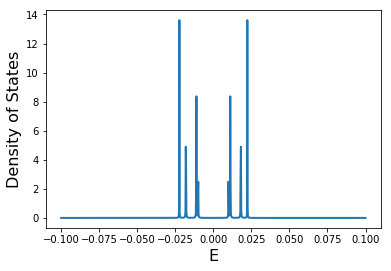

In [170]:
physics = Physics()

physics.N_z = 2
physics.N_phi = 6
physics.flux = 0.0
physics.t_z = 1
physics.t_phi = 0.005*np.exp(1j*2*np.pi*physics.flux/physics.N_phi)
physics.Delta = 1e-2
physics.mu = 1
physics.eta = 1e-8
physics.kT = 1e-4

E_vec = np.linspace(-0.1,0.1,1000)
a_vec = np.array([calc_dos(E,physics) for E in E_vec])


plt.plot(E_vec,a_vec,linewidth=2.0)
plt.xlabel(r"E",fontsize=16)
plt.ylabel(r"Density of States",fontsize=16)

data_path = "/Users/sandesh/repos/bdg-nanowire/plot_data/dos_sub_super"
plt.savefig(data_path + '.png',dpi=300,bbox_inches='tight')
res = {'physics' : physics,'E_vec' : E_vec,'a_vec' : a_vec}
np.save(data_path + '.npz',res)

Once the function creating the Hamiltonian has been defined, I follow the standard NEGF results to calculate current (I) as a function of E.

In [203]:
 def current_E(E,physics):
    N_phi = physics.N_phi
    N_z =  physics.N_z
    flux = physics.flux
    
    eta = physics.eta
    kT = physics.kT
    mu_1 = physics.mu_1
    mu_2 = physics.mu_2
    mu = 0.5*(mu_1 + mu_2)
    Delta1 = physics.Delta1
    Delta2 = physics.Delta2
    
    t_z = physics.t_z
    t_phi = physics.t_phi
    
    # create the physical paramters dictionaries to create the respective Hamiltonians for S1-N-S2
    physical_parameters_N = Physics()
    physical_parameters_N.N_z = N_z
    physical_parameters_N.N_phi = N_phi
    physical_parameters_N.Delta = 0.0
    physical_parameters_N.t_z = t_z 
    physical_parameters_N.t_phi = t_phi 
    physical_parameters_N.mu = mu
    physical_parameters_N.flux = flux 
    
    
    physical_parameters_S1 = Physics()
    physical_parameters_S1.N_z = N_z
    physical_parameters_S1.N_phi = N_phi
    physical_parameters_S1.Delta = Delta1
    physical_parameters_S1.t_z = t_z 
    physical_parameters_S1.t_phi = t_phi 
    physical_parameters_S1.mu = mu_1
    physical_parameters_S1.flux = flux 
    
    physical_parameters_S2 = Physics()
    physical_parameters_S2.N_z = N_z
    physical_parameters_S2.N_phi = N_phi
    physical_parameters_S2.Delta = Delta2
    physical_parameters_S2.t_z = t_z 
    physical_parameters_S2.t_phi = t_phi 
    physical_parameters_S2.mu = mu_2
    physical_parameters_S2.flux = flux 
    
    def surface_g(E,physical_parameters):
        # create a dummy Hamiltonian with two layers to get the hopping element beta and the layer element alpha
        
        dummy_params = Physics()
        dummy_params = physical_parameters
        dummy_params.N_z = 2
        
        H_mat = calc_H(dummy_params)

        N_dof_lat = N_phi*2

        alpha = H_mat[:N_dof_lat,:N_dof_lat]
        beta = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        err = 1.0
        iter_count = 0
        iter_limit = 100000
        err_limit = 1e-6

        g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        g_old = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        # iterate over iter_limit iterations or until err < err_limit
        for i in range(iter_limit):
            g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha - np.dot(np.dot(np.conj(beta.T),g),beta))
            g = 0.5*(g + g_old)

            err = np.linalg.norm(g-g_old)/np.sqrt(np.linalg.norm(g)*np.linalg.norm(g_old))
            g_old = g
            if(err < err_limit):
                #print("Finished at",i,"Error :",err)
                break;
            if(i == (iter_limit - 1)):
                print("iter_limit hit in calculation of surface_g",err)
        return g
    
    g_1 = surface_g(E,physical_parameters_S1)
    g_2 = surface_g(E,physical_parameters_S2)
    
    H_mat = calc_H(physical_parameters_N)
    
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.dot(np.dot(np.conj(beta_layer.T),g_1),beta_layer)
    sigma_mini_2 = np.dot(np.dot(np.conj(beta_layer.T),g_2),beta_layer)
    
    sigma_1 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_1[:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.conj(sigma_1).T)
    
    sigma_2 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_2[-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.conj(sigma_2).T)    
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu,kT):
        return np.array([[fermi(E - mu,kT),0],[0,fermi(E + mu,kT)]])
        
    F1 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu_1-mu,kT))
    F2 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu_2-mu,kT))
    
    sigma_in = np.dot(gamma_1,F1) + np.dot(gamma_2,F2)

    G = np.linalg.inv((E + 1j*eta)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.conj(G).T)
    
    G_n = np.dot(np.dot(G,sigma_in),np.conj(G).T)
    
    #I_mat = 1j*(np.dot(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
    #        - np.dot(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
    I_mat = 1j*(np.dot(H_mat,G_n) - np.dot(G_n,H_mat))
    # current = electron current - hole current
    I = np.real(np.trace(I_mat[0:2*N_phi:2,0:2*N_phi:2]-I_mat[1:2*N_phi:2,1:2*N_phi:2]))
    return I

class Physics:
    def __init__(self):
        return



In [309]:
physics = Physics()

phi = np.pi/9

physics.N_z = 2
physics.N_phi = 10
physics.flux = 2.0
physics.t_z = 1
physics.t_phi = 1*np.exp(1j*2*np.pi*physics.flux/physics.N_phi)
physics.Delta1 = 1e-2
physics.Delta2 = 1e-2*np.exp(1j*phi)
physics.mu_1 = 2
physics.mu_2 = 2
physics.eta = 1e-4
physics.kT = 1e-5

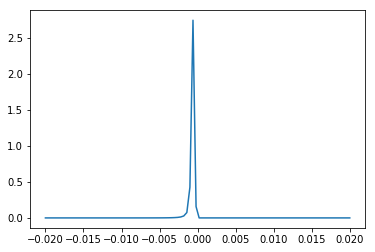

In [310]:
I = [current_E(E,physics) for E in np.linspace(0.-2*physics.Delta1,2*physics.Delta1,100)]
#I = [current_E(E,physics) for E in np.linspace(-2,2,100)]
plt.plot(np.linspace(-2*physics.Delta1,2*physics.Delta1,100),I)

In [311]:
import scipy.integrate
def calc_I_phi(x,phi): 
    x.Delta2 = abs(x.Delta2)*np.exp(1j*phi)
    return scipy.integrate.quad(lambda y : current_E(y,x),-15e-3,-5e-3,epsrel=1e-2,points=[-1e-2])
import time
st = time.time()
I_phi = [calc_I_phi(physics,phi) for phi in np.linspace(0,2*np.pi,50)]


92.70852589607239


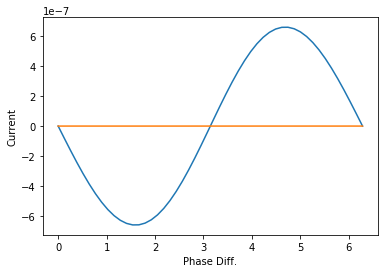

In [312]:
plt.plot(np.linspace(0,2*np.pi,len(I_phi)),I_phi)
plt.xlabel('Phase Diff.')
plt.ylabel('Current')
print(time.time()-st)

In [308]:
res = {'physics' : physics,'I_phi' : I_phi}
save_dict(res,suffix="subband-E-1")

0.0
180.98830008506775
0.555555555556
638.1976590156555


KeyboardInterrupt: 

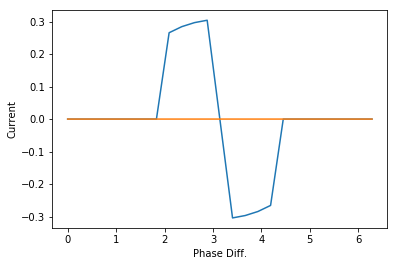

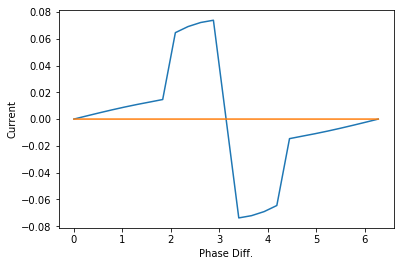

In [11]:
N_f = 10
flux_lin = np.linspace(0.0,5,N_f)
for i in range(N_f):
    physics = Physics()

    physics.N_z = 2
    physics.N_phi = 10
    physics.flux = flux_lin[i]
    physics.t_z = 1
    physics.t_phi = 1*np.exp(1j*2*np.pi*physics.flux/physics.N_phi)
    physics.Delta1 = 1e-2
    physics.Delta2 = 1e-2*np.exp(1j*phi)
    physics.mu_1 = 2
    physics.mu_2 = 2
    physics.eta = 1e-6
    physics.kT = 1e-5

    import scipy.integrate
    def calc_I_phi(x,phi): 
        x.Delta2 = abs(x.Delta2)*np.exp(1j*phi)
        return scipy.integrate.quad(lambda y : current_E(y,x),-5e-3,5e-3,epsrel=1e-4,points=[0e-2])
    import time
    st = time.time()
    I_phi = [calc_I_phi(physics,phi) for phi in np.linspace(0,2*np.pi,25)]
    print(physics.flux)
    plt.figure(i+1)
    plt.plot(np.linspace(0,2*np.pi,len(I_phi)),I_phi)
    plt.xlabel('Phase Diff.')
    plt.ylabel('Current')
    print(time.time()-st)

In [223]:
I_phi

[(4.687255005696094e-18, 5.677782110614789e-18),
 (0.0012116754194972325, 1.0731157578413564e-07),
 (0.002417597456708198, 1.994035994662283e-07),
 (0.0036120606769792112, 4.786053441807516e-07),
 (0.004789461037043262, 1.540985965503539e-06),
 (0.0059443720506713125, 3.1016281085584742e-06),
 (0.007071656907022689, 1.0095671699485425e-06),
 (0.008166659125440071, 1.4572151003312416e-05),
 (0.009225536051104101, 3.4116370457145696e-05),
 (0.01024595159732204, 3.760398227872937e-05),
 (0.011228448696639711, 1.3090315088820485e-06),
 (0.012179855754081283, 1.5928252228822098e-06),
 (0.013122379192560938, 2.0684660083065227e-06),
 (0.014123912680744454, 0.00012682814036133426),
 (0.01543976951451105, 2.0467671626006254e-05),
 (0.018923784051582956, 4.9420283845915194e-06),
 (0.05602133662344757, 1.338687771513115e-05),
 (0.06341176085143899, 0.0005034395823359586),
 (0.06586037591903204, 1.6051117725571044e-05),
 (0.06724728345037705, 0.00038258755319261605),
 (0.0678346769499544, 9.14875